In [1]:
from pathlib import Path
import hydra_zen
from omegaconf import OmegaConf 
import torch
import xarray as xr
import lightning as L
import numpy as np
import importlib
import matplotlib.pyplot as plt
import glob
from data_module import WindDirectionDataModule
import simple_conv
importlib.reload(simple_conv)
from simple_conv import MyModel
# import simple_conv_no_mdn
# importlib.reload(simple_conv_no_mdn)
# from simple_conv_no_mdn import MyModel

# Test

In [2]:
def load_model(model_path, inc=2, outc=1, hid=64, depth=5, down=2, num_gaussians=3):#, num_gaussians=3
    checkpoint = torch.load(model_path)
    model = MyModel(inc=inc, hid=hid, depth=depth, down=down, outc=outc, num_gaussians=num_gaussians)#, num_gaussians=num_gaussians
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint


def load_data(path, checkpoint, inc=2):
    data_module = WindDirectionDataModule(test_data_paths=path, inc=inc)
    data_module.train_mean = checkpoint['train_mean']
    data_module.train_std = checkpoint['train_std']
    data_module.setup(stage='predict')
    dataloader = data_module.test_dataloader()
    return dataloader, data_module


# def predict(model, dataloader):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device) 
#     y_pred = []
#     uncertainty = []
#     all_pi = []
#     all_mu = []
#     all_sigma = []
#     model.eval()
#     with torch.no_grad():
#         for batch in dataloader:
#             X, _ = batch
#             X = X.to(device) 
#             preds = model(X)
#             y_pred.append(preds)
#     y_pred = torch.concat(y_pred).cpu()

#     return y_pred.squeeze()

def predict(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device) 
    y_pred = []
    uncertainty = []
    all_pi = []
    all_mu = []
    all_sigma = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            X, _ = batch
            X = X.to(device) 
            preds, uncer, pi, sigma, mu = model(X)
            y_pred.append(preds)
            uncertainty.append(uncer)
            all_pi.append(pi)
            all_mu.append(mu)
            all_sigma.append(sigma)
    y_pred = torch.concat(y_pred).cpu()
    uncertainty = torch.concat(uncertainty).cpu()
    all_pi = torch.concat(all_pi).cpu()
    all_mu = torch.concat(all_mu).cpu()
    all_sigma = torch.concat(all_sigma).cpu()
    return y_pred.squeeze(), uncertainty, all_pi, all_sigma, all_mu

In [3]:
# best_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-06/12-17-45/0/wind_direction_model/1_4_256_5_vv_rob/checkpoints/best-checkpoint.ckpt"
# best_model_1 = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-07/11-03-52/0/wind_direction_model/1_4_256_5_vv_ren/checkpoints/best-checkpoint.ckpt"
# best_mdn = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-07/13-07-34/0/wind_direction_model/1_4_256_5_3_vv_ren/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-09/09-31-42/0/wind_direction_model/1_2_64_5_2_vv_rob_newmdn_loss_mdncomb/checkpoints/best-checkpoint.ckpt"
#best_bias_mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-19/15-55-00/0/wind_direction_model/1_2_64_5_2_rob_newmdn_weight_decay/checkpoints/best-checkpoint.ckpt"
# best_bias_mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-20/12-55-16/0/wind_direction_model/1_2_64_7_2_rob_newmdn_weight_decay/checkpoints/best-checkpoint.ckpt"


In [4]:
# model_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-05/12-49-06/0/wind_direction_model/1_vv_rob/checkpoints/best-checkpoint.ckpt"
# model_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-05/14-18-22/0/wind_direction_model/1_depth_vv_rob/checkpoints/best-checkpoint.ckpt"
# deep_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-05/13-48-46/0/wind_direction_model/1_depth_vv_rob/checkpoints/best-checkpoint.ckpt"
# res_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-05/14-40-49/0/wind_direction_model/1_depth_vv_rob/checkpoints/best-checkpoint.ckpt" 
# f_res_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-05/14-59-20/0/wind_direction_model/1_depth_vv_rob/checkpoints/best-checkpoint.ckpt"
# test = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-07/11-03-52/0/wind_direction_model/1_4_256_5_vv_ren/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-08/14-50-06/0/wind_direction_model/1_4_256_5_2_vv_rob_newmdn_loss/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-09/08-53-06/0/wind_direction_model/1_2_256_5_2_vv_rob_newmdn_loss_mdncomb/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-09/10-15-34/0/wind_direction_model/1_2_64_5_2_vv_ren_newmdn/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-09/12-26-54/0/wind_direction_model/1_2_64_5_2_vv_ren_rob_newmdn/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-09/14-23-59/0/wind_direction_model/1_2_64_5_2_vv_ren_rob_newmdn/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-21/11-53-48/0/wind_direction_model/1_2_64_7_2_ren_rob_newmdn_weight_decay/checkpoints/best-checkpoint.ckpt"
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-23/15-23-36/7/wind_direction_model/2_2_128_8_2_ren_rob_newmdn_dec_enhanced_no_norm/checkpoints/best-checkpoint.ckpt"
model_old = '/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-27/15-22-23/2/wind_direction_model/2_4_128_7_simple_ren_ds_VV_VH_mdn_minim/checkpoints/best-checkpoint.ckpt'
model, checkpoint = load_model(model_path=model_old, inc=2, hid=128, depth=7, down=4, outc=3, num_gaussians=2)#num_gaussians=2


In [5]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset_180/test_dataset_norm.nc"

In [7]:
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=2)
# y_pred = predict(model, dataloader)
y_pred, uncertainty, all_pi, all_mu, all_sigma = predict(model, dataloader)

In [10]:
# def normalize_dataset(X, checkpoint, inc=1):
#     mean = checkpoint['train_mean']
#     std = checkpoint['train_std']
#     if inc == 2:
#         mean = mean.view(1, -1, 1, 1)  
#         std = std.view(1, -1, 1, 1) 
#     X = (X - mean) / std
#     return X

In [11]:
# ds = xr.open_dataset(ds_path)
# x = torch.Tensor(ds.sel(pol='VV').sigma0_detrend.values)
# x = x[:, None, :, :]
# x = normalize_dataset(x, checkpoint, inc=1)

In [12]:
# preds, uncer, pi, sigma, mu = model(x)
# y_pred = np.rad2deg(preds.squeeze().detach().numpy()) %180

In [13]:
# all_pi = pi.detach().numpy()
# all_mu = mu.detach().numpy()
# all_sigma = sigma.detach().numpy()

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

# t = 0
# k = 0
# k1 = 1
# x = np.linspace(-3, np.pi, 1000)

# gaussian_components = all_pi[t][k] * (1 / (np.sqrt(2 * np.pi * all_sigma[t][k]**2))) * np.exp(- (x - all_mu[t][k])**2 / (2 * all_sigma[t][k]**2))
# gaussian_components_1 = all_pi[t][k1] * (1 / (np.sqrt(2 * np.pi * all_sigma[t][k1]**2))) * np.exp(- (x - all_mu[t][k1])**2 / (2 * all_sigma[t][k1]**2))

# # mixture_pdf = np.sum(gaussian_components, axis=0)

# plt.figure(figsize=(8, 6))
# plt.plot(x, gaussian_components, label=f'Mixture Density 1 mu={np.rad2deg(all_mu[t][k])}, sigma={all_sigma[t][k]:.3}, pi={all_pi[t][k]:.3}')
# plt.plot(x, gaussian_components_1, label=f'Mixture Density 2 mu={all_mu[t][k1]:.3}, sigma={all_sigma[t][k1]:.3}, pi={all_pi[t][k1]:.3}')

# plt.xlabel('x')
# plt.ylabel('Density')
# plt.title('Mixture Density Network PDF')
# plt.legend()
# plt.grid(True)
# plt.show()


In [15]:
# x = np.linspace(0, np.deg2rad(180), 180)
# sigma=0.5
# mu = np.deg2rad(90)
# p1 = (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x+np.deg2rad(180)-mu)**2/(2*sigma**2))
# p0 = (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x-mu)**2/(2*sigma**2))
# p2 = (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x-np.deg2rad(180)-mu)**2/(2*sigma**2))
# plt.plot(np.rad2deg(x),p0+p1+p2);plt.grid()
# plt.plot(np.rad2deg(x),p0);plt.grid()

In [16]:
tst_ds = xr.open_dataset(ds_path)

# Analyse

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

def get_histogram_2d_variables(x_column, y_column, nbins=100):
    x_min, x_max = np.min(x_column), np.max(x_column)
    y_min, y_max = np.min(y_column), np.max(y_column)
    
    kernel = stats.gaussian_kde([x_column, y_column])
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        
    return xi, yi, zi.reshape(xi.shape)

def hist2d_prediction_vs_reference(x, y, pred_std, pol, title, mod=False, mission='S1'):
    X, Y, Z = get_histogram_2d_variables(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=(6, 1), height_ratios=(1, 6),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
        
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.pcolormesh(X, Y, Z, shading='auto', cmap='Blues')
    ax.set_xlabel('Reference angle (°)', fontsize=14)
    ax.set_ylabel('Predicted angle (°)', fontsize=14)
    ax.set_xlim(0, 180)
    ax.set_ylim(0, 180)
    
    nbins = 90
    binwidth = 180 / nbins

    bins = np.arange(0, 180 + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, alpha=0.75)
    ax_histx.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histx.set_xlim(0, 180)
    ax_histy.hist(y, bins=bins, orientation='horizontal', alpha=0.75)
    ax_histy.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histy.set_ylim(0, 180)

    ax.grid(linestyle='--', color='gray', alpha=0.9)
    
    x_series = pd.Series(x)
    y_series = pd.Series(y)
    
    diff_serie = (y_series - x_series % 180).apply(lambda v: -1 * np.sign(v) * 180 + v if np.abs(v) > 90 else v)
    bias = diff_serie.mean()
    std = diff_serie.std()
    nb_points = len(x)

    txt_str = 'Number of points: %d \nBias: %.2f° | Std: %.2f°' % (nb_points, bias, std)
    if pred_std:
        title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min, STD predicted: [0 - {pred_std.values.max():.2f}]°'
    else:
        if mod:
            title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min {title} mod90'
            
        else:
            title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min {title}'
    props = dict(boxstyle='square', facecolor='white')
        
    ax.text(0.05, 0.95, txt_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.plot([0, 180], [0, 180], color='k', linestyle='--')
    plt.suptitle(title_str, fontsize=20)
        
    plt.show()


In [19]:
y_hy2b = tst_ds.sel(pol='VV').hy2b_wind_direction.values
y_pred_rob = tst_ds.sel(pol='VV').mean_wind_direction.values

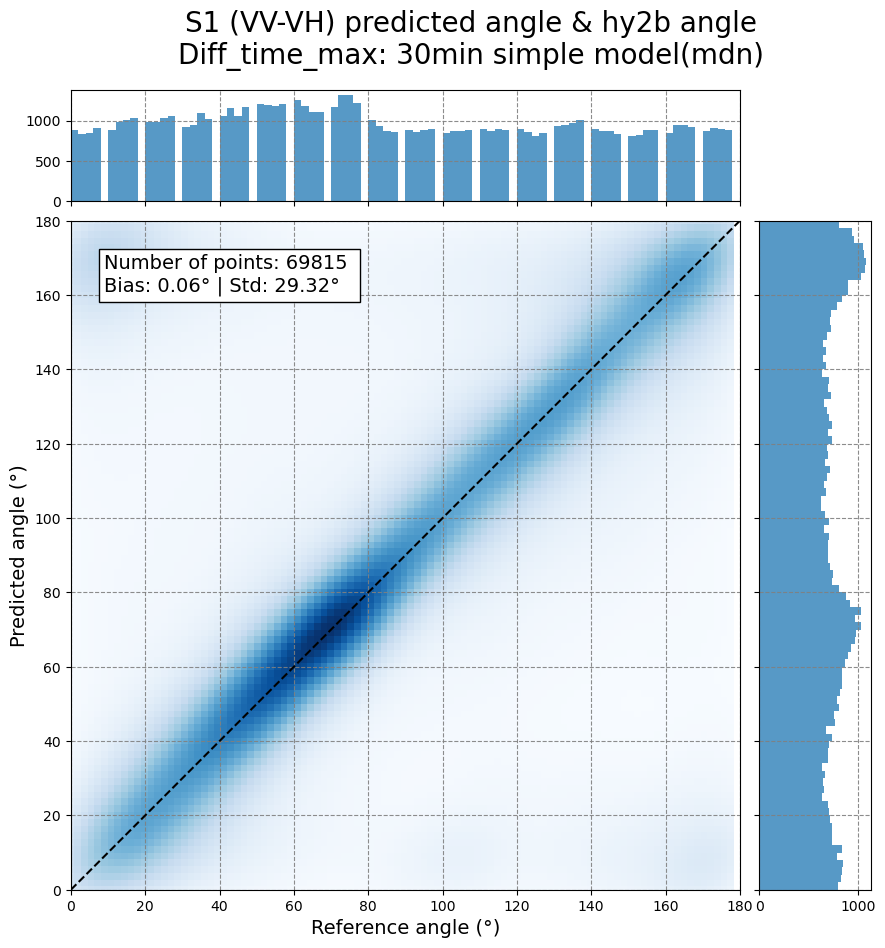

In [21]:
heading_angles = tst_ds.sel(pol='VV').ground_heading.values[:,0,0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple model(mdn)', pol='VV-VH')

In [55]:
# heading_angles = tst_ds.sel(pol='VV').ground_heading.values[:,0,0]
# y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
# hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple model(mdn)', pol='VV')

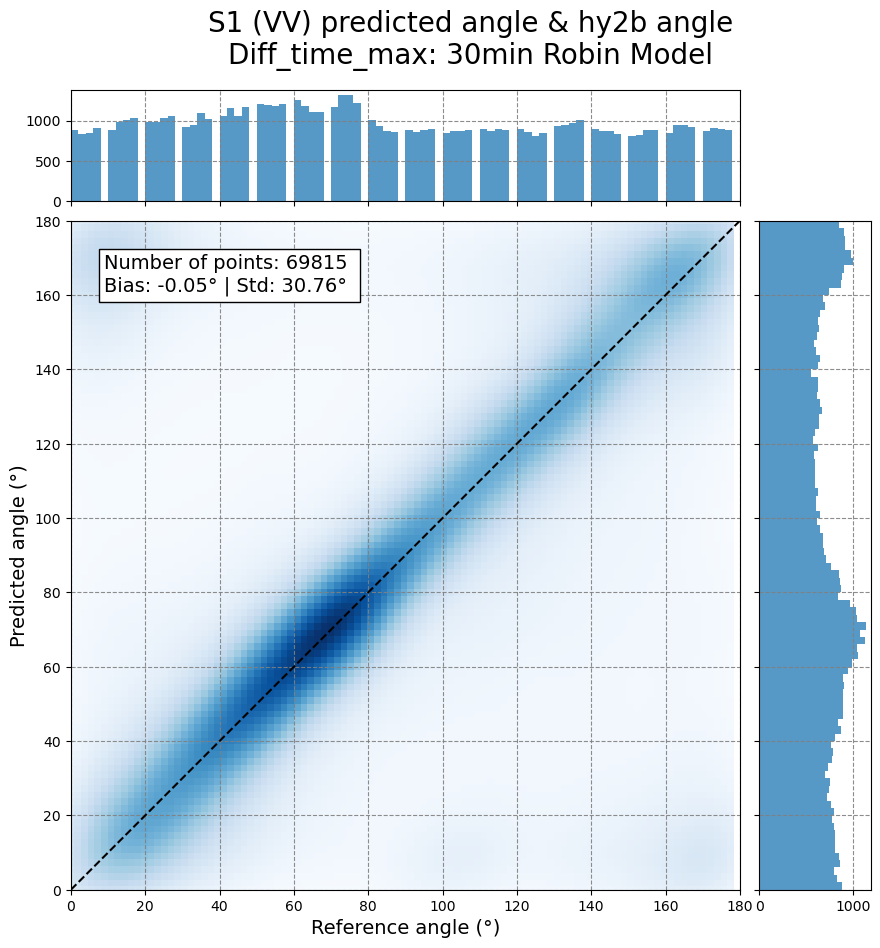

In [56]:
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=np.array(y_pred_rob%180), pred_std=None, title='Robin Model', pol='VV')

In [44]:
# def loss_cos(y_true, y_pred, ambi=False):
#     err = y_pred - y_true
#     if not ambi:
#         err = err / 2
#     loss = 1 - torch.square(torch.cos(err))
#     return torch.mean(loss)

# def err_calculation(y_true, y_pred):
#     ang = 180
#     angular_diff = torch.abs(y_true - y_pred)
#     err = torch.min(angular_diff, ang - angular_diff).mean()
#     return err

In [45]:
# y_true = torch.tensor(np.deg2rad(y_hy2b%180), dtype=torch.float32)
# y_pred = torch.tensor(np.deg2rad(y_pred_norm%180), dtype=torch.float32)

# test_loss = loss_cos(y_true, y_pred)
# test_err = err_calculation(y_true, y_pred)
# print(test_loss, test_err)

tensor(0.1120) tensor(0.4497)


# Prediction


In [4]:
# mdn_model = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-23/15-23-36/1/wind_direction_model/2_2_64_6_2_ren_rob_newmdn_dec_enhanced_no_norm/checkpoints/best-checkpoint.ckpt"
# mdn_model = '/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-27/15-22-23/2/wind_direction_model/2_4_128_7_simple_ren_ds_VV_VH_mdn_minim/checkpoints/best-checkpoint.ckpt'

mdn_model = '/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/2024-08-27/15-22-23/5/wind_direction_model/2_4_256_7_simple_ren_ds_VV_VH_mdn_minim/checkpoints/best-checkpoint.ckpt'

model, checkpoint = load_model(model_path=mdn_model, inc=2, hid=256, depth=7, down=4, outc=3, num_gaussians=2)


In [5]:
# path = "/raid/localscratch/jrmiadan/analyse/analyse_ds/s1_ds_vv_vh.nc"
path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset_180/test_dataset_norm.nc"

ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 17GB
Dimensions:                          (tile: 69815, tile_line: 44,
                                      tile_sample: 44, pol: 2)
Coordinates:
    line                             (tile, tile_line) float64 25MB ...
    sample                           (tile, tile_sample) float64 25MB ...
  * pol                              (pol) <U2 16B 'VV' 'VH'
Dimensions without coordinates: tile, tile_line, tile_sample
Data variables: (12/20)
    spatial_ref                      int64 8B ...
    ground_heading                   (pol, tile, tile_line, tile_sample) float32 1GB ...
    land_mask                        (pol, tile, tile_line, tile_sample) int8 270MB ...
    incidence                        (pol, tile, tile_line, tile_sample) float64 2GB ...
    longitude                        (pol, tile, tile_line, tile_sample) float64 2GB ...
    latitude                         (pol, tile, tile_line, tile_sample) float64 2GB ...
    ...                               ...
    hy2b_wind_direction              (tile) float64 559kB ...
    hy2b_wind_speed                  (tile) float64 559kB ...
    hy2b_intensity_of_precipitation  (tile) float64 559kB ...
    hy2b_probability_of_rain         (tile) float64 559kB ...
    ref_angles                       (tile) float64 559kB ...
    sigma0_detrend_norm              (tile, pol, tile_line, tile_sample) float64 2GB ...
Attributes: (12/17)
    short_name:                SENTINEL1_DS:S1B_IW_GRDH_1SDV_20190116T145933_...
    safe:                      S1B_IW_GRDH_1SDV_20190116T145933_20190116T1500...
    swath:                     IW
    ipf:                       2.91
    platform:                  SENTINEL-1B
    start_date:                2019-01-16 14:59:33.992695
    ...                        ...
    polarizations:             VV VH
    processing_level:          GRDH
    main_footprint:            POLYGON ((47.94800567393426 3.99400085076889, ...
    platform_heading(degree):  -11.97285939090958
    sar_path:                  /home/datawork-cersat-project/mpc-sentinel1/da...
    scat_path:                 /home/datawork-cersat-public/provider/knmi/sat...

In [6]:
dataloader, data_module = load_data(path=path, checkpoint=checkpoint, inc=2)
y_pred, uncertainty, all_pi, all_mu, all_sigma = predict(model, dataloader)

In [7]:
heading_angles = ds.sel(pol='VV').ground_heading.values[:,0,0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
y_hy2b = ds.sel(pol='VV').hy2b_wind_direction.values

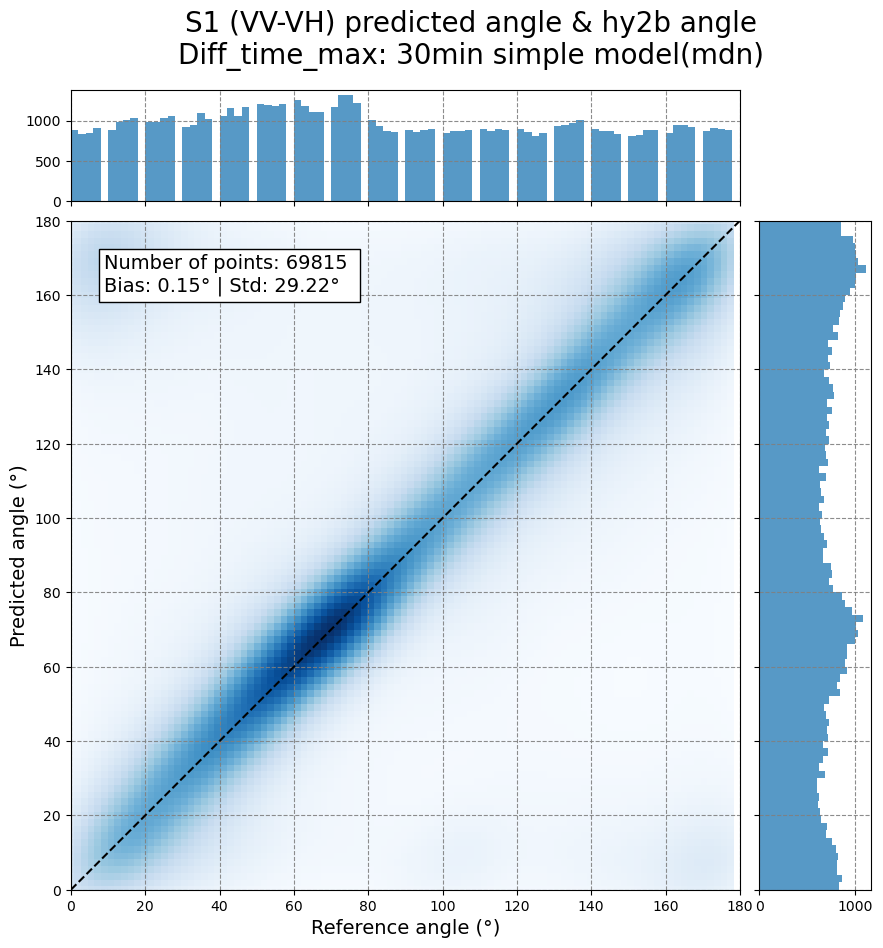

In [8]:
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple model(mdn)', pol='VV-VH')

# filter by uncertainty

In [9]:
unc = (np.rad2deg(uncertainty.squeeze()))%180

/tmp/ipykernel_1306278/3475116999.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  unc = (np.rad2deg(uncertainty.squeeze()))%180


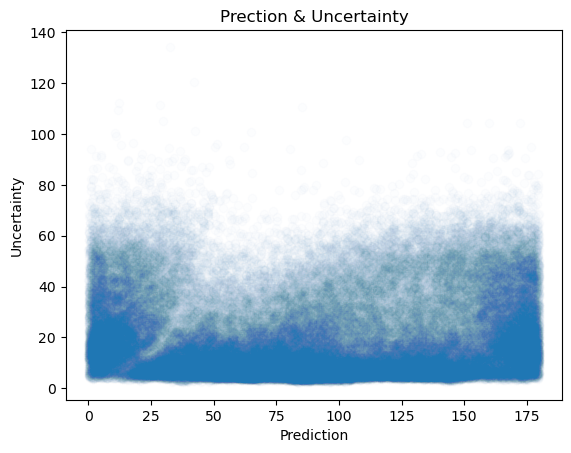

In [10]:
plt.scatter(np.rad2deg(np.array(y_pred))%180, unc, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Uncertainty')
plt.title('Prection & Uncertainty')
plt.show()

In [11]:
df = pd.DataFrame({
    'y_true' : y_hy2b,
    'y_pred_norm_128': y_pred_norm,
    'uncertainty_128': unc
})

In [12]:
df = pd.read_csv('./df_pred.csv')

In [14]:
df['y_pred_norm_256'] = y_pred_norm
df['uncertainty_256'] = unc

In [31]:
ds.mean_wind_direction.values

array([[  3.43474922,  10.32603247,  12.60481569, ..., 165.76258814,
        158.74162096, 158.66630201],
       [  8.42555535,   7.24599613,  17.20767415, ...,  41.44067447,
          8.97840642,  15.5978398 ]])

In [32]:
df['y_pred_rob_vv'] = ds.sel(pol='VV').mean_wind_direction.values
df['y_pred_rob_vh'] = ds.sel(pol='VH').mean_wind_direction.values

In [33]:
df.to_csv('./df_pred.csv', index=False)

In [18]:
df_40 = df[df['uncertainty']<10]

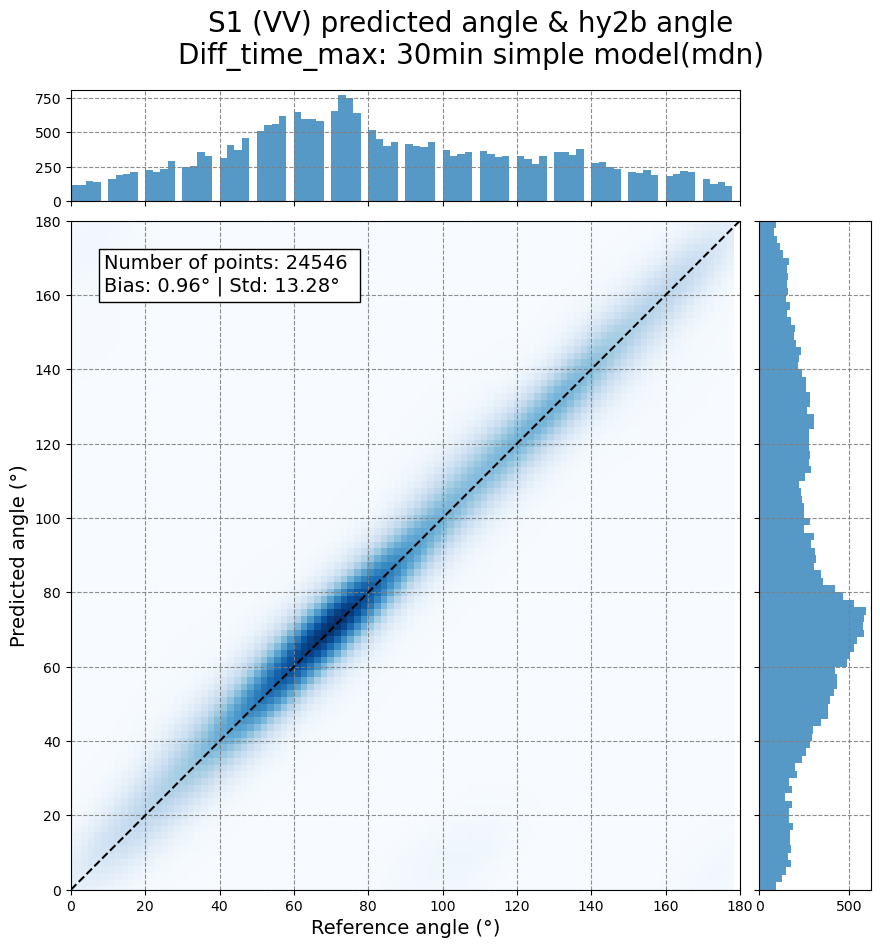

In [21]:
hist2d_prediction_vs_reference(x=np.array(df_40['y_true'])%180, y=np.array(df_40['y_pred_norm'])%180, pred_std=None, title='simple model(mdn)', pol='VV', mission='S1')

In [111]:
df

,y_true,y_pred_norm_128,uncertainty_128,y_pred_norm_256,uncertainty_256,y_pred_rob_vv,y_pred_rob_vh
0,180.0,0.959656,5.813537,179.120132,4.826562,3.434749,8.425555
1,185.0,10.311569,3.838064,11.877655,4.193725,10.326032,7.245996
2,200.0,16.825623,4.994570,13.331024,3.872831,12.604816,17.207674
3,220.0,19.175370,38.678997,13.515350,19.768755,68.139045,59.846954
4,240.0,122.419464,53.472800,117.164017,11.547165,11.775301,19.405392
...,...,...,...,...,...,...,...
69810,7.5,15.308716,39.526104,4.503963,16.367115,178.230863,160.909899
69811,5.0,171.744110,21.779585,172.877960,17.377426,168.370758,14.984333
69812,2.5,174.295060,27.181992,165.995361,18.021669,165.762588,41.440674
69813,357.5,169.082700,13.807508,163.083771,10.930461,158.741621,8.978406


In [119]:
def uncert(df, hid):
    uncert_val = []
    mean_theta_dif = []
    point_percent = []
    
    total_points = len(df)
    for i in range(5, 45, 5):  
        df_filt = df[df[f'uncertainty_{hid}'] < i] 
        uncert_val.append(i)
        mean_theta_dif.append(np.mean(abs(df_filt['y_true'] - df_filt[f'y_pred_norm_{hid}'])%90))
        num_points = len(df_filt)  
        mean_theta_dif
        
        percent_points = (num_points / total_points)   
        point_percent.append(percent_points)
    return uncert_val, point_percent, mean_theta_dif

In [120]:
uncert_val_128, point_percent_128, mean_theta_dif_128 = uncert(df, hid='128')
uncert_val_256, point_percent_256, mean_theta_dif_256 = uncert(df, hid='256')


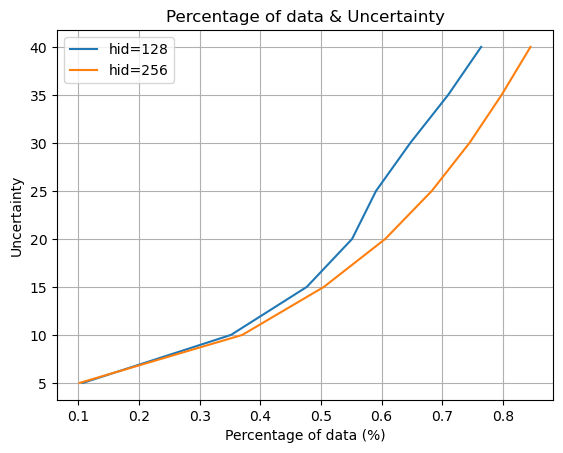

In [121]:
plt.plot(point_percent_128, uncert_val_128, label='hid=128')
plt.plot(point_percent_256, uncert_val_256, label='hid=256')

plt.xlabel('Percentage of data (%)')
plt.ylabel('Uncertainty')
plt.title('Percentage of data & Uncertainty')
plt.legend()
plt.grid()
plt.show()

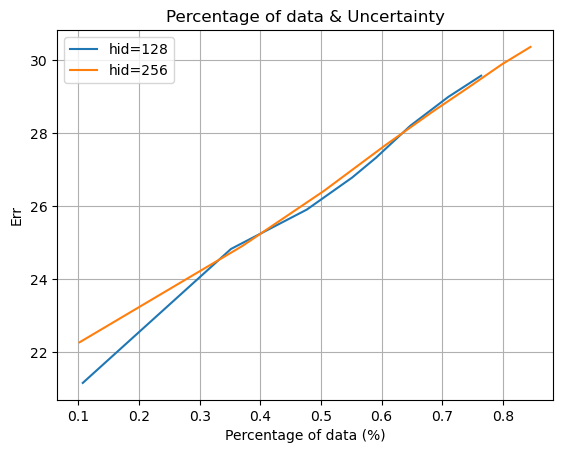

In [125]:
plt.plot(point_percent_128, mean_theta_dif_128, label='hid=128')
plt.plot(point_percent_256, mean_theta_dif_256, label='hid=256')

plt.xlabel('Percentage of data (%)')
plt.ylabel('Err')
plt.title('Percentage of data & Uncertainty')
plt.legend()
plt.grid()
plt.show()

# uncertainty & error

In [79]:
theta_dif_rob = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_rob_vv'])%180
theta_dif_128 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_128'])%180
theta_dif_256 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_256'])%180

In [94]:
uncer_err_df = pd.DataFrame({
    'uncertainty': df['uncertainty_128'].values,
    'theta_dif' : theta_dif_128.values
    
})

In [95]:
uncer_err_df_sorted = uncer_err_df.sort_values(by='theta_dif')

In [108]:
uncer_err_df_filt = uncer_err_df[uncer_err_df['theta_dif']<50] 

In [ ]:
for i in range(5,45,5):
    uncer_err_df_sorted['uncertainty']<i

ValueError: x and y must be the same size

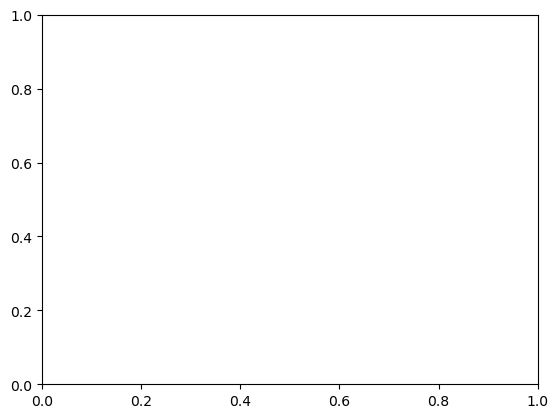

In [110]:
plt.scatter(uncer_err_df_sorted['theta_dif'].mean(), uncer_err_df_sorted['uncertainty'], label='hid=128(VV-VH)')
# plt.scatter(uncer_err_df_filt['theta_dif'], uncer_err_df_filt['uncertainty'], label='hid=128(VV-VH)', alpha=0.01)

# plt.scatter(df['uncertainty_256'], theta_dif_256, label='hid=256(VV-VH)')

plt.xlabel('Absolute theta difference')
plt.ylabel('uncertainy')
plt.title('Wind speed & Absolute theta difference mod 90\nS1')
plt.grid()
# plt.xlim(0,35)
# plt.ylim(0, 90)
plt.legend()
plt.show()

# wind speed

In [44]:
def get_fit_function(sig, theta_dif, coef, coef_name='.', mod=False, p=8):
    res = np.zeros_like(sig, dtype=float)
    if coef_name == 'sig0_detr':
        coef_val = 10*np.log10(coef)
    else:
        coef_val = coef
    if mod:
        theta_mod = theta_dif % 90
    else:
        theta_mod = theta_dif
    for cpt, _sig in enumerate(sig):
        cond = np.abs(coef_val - _sig) < 2.5
        if np.any(cond):
            res[cpt] = np.mean(np.array(theta_mod)[cond])
        else:
            res[cpt] = np.nan
            
    return np.polyfit(sig, res, p), res
    

def plot_theta_difference(data_x, theta_dif, sig, res, fit_params, mission, pol, plot_type='wind_speed', mod=False, a=0.01):

    if plot_type == 'sigma0_detrend':
        log_sig = 10 * np.log10(data_x)
        x_label = 'Log mean sigma0 detrend (dB)'
        title_suffix = 'log mean sigma0 detrend'
        x_data = log_sig
    elif plot_type == 'wind_speed':
        x_label = 'Wind speed m/s'
        title_suffix = 'wind speed'
        x_data = data_x
    else:
        raise ValueError("Invalid plot_type. Choose 'wind_speed' or 'sigma0_detrend'.")

    if mod:
        plt.plot(x_data, theta_dif % 90, 's', alpha=a)
        y_label = 'Absolute theta difference mod 90(simple_conv)'
    else:
        plt.plot(x_data, theta_dif, 's', alpha=a)
        y_label = 'Absolute theta difference'

    plt.plot(sig, res, 'r', lw=3, label='Mean absolute theta difference')

    get_abs_theta_dif = np.poly1d(fit_params)

    t = np.linspace(min(sig), max(sig), 100)
    plt.plot(t, get_abs_theta_dif(t), "--b", label="Fit function", lw=1.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} vs {title_suffix} \n{mission}({pol})')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return get_abs_theta_dif

def theta_dif_prediction(df_upol, sig, get_abs_theta_dif, coef_name='.'):
    if coef_name == 'sig0_detr':
        in_val = 10 * np.log10(df_upol['sig0_detr_mean'].values)
    else:
        in_val = df_upol['hy2b_wind_speed'].values
        
    in_val = np.clip(in_val, sig.min(), sig.max())
    in_val = np.nan_to_num(in_val, nan=-40)
    pred_abs_theta_dif = get_abs_theta_dif(in_val)
    
    if coef_name == 'sig0_detr':
        df_upol['theta_dif_sig0_detr'] = pred_abs_theta_dif
    else:
        df_upol['theta_dif_wspeed'] = pred_abs_theta_dif

    
    return df_upol

In [42]:
wind_speed = np.array(ds['hy2b_wind_speed'].values)
# theta_dif = abs(tst_ds.hy2b_wind_direction.values - ds.sel(pol=pol).mean_wind_direction.values)%180

In [73]:
theta_dif_rob = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_rob_vv'])%180
theta_dif_128 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_128'])%180
theta_dif_256 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_256'])%180



In [46]:
sig = np.arange(0, 30, 1)
mod = True
wspd_params, res = get_fit_function(sig=sig, theta_dif=theta_dif, coef=wind_speed, mod=mod)
wspd_params

array([ 1.63871859e-08, -2.24823552e-06,  1.18169213e-04, -3.02837930e-03,
        3.87717127e-02, -2.09006592e-01,  9.70959454e-02, -6.53286430e-01,
        3.62982803e+01])

In [74]:
wspd_params, res_rob = get_fit_function(sig=sig, theta_dif=theta_dif_rob, coef=wind_speed, mod=mod)
wspd_params, res_128 = get_fit_function(sig=sig, theta_dif=theta_dif_128, coef=wind_speed, mod=mod)
wspd_params, res_256 = get_fit_function(sig=sig, theta_dif=theta_dif_256, coef=wind_speed, mod=mod)



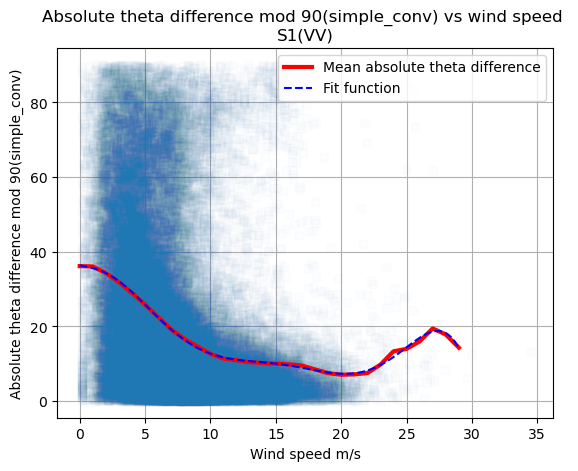

In [47]:
mission = 'S1'
pol = 'VV'
get_abs_theta_dif = plot_theta_difference(data_x=wind_speed, theta_dif=theta_dif, sig=sig, res=res, fit_params=wspd_params, mission=mission, 
                                          pol=pol, plot_type='wind_speed', mod=mod)

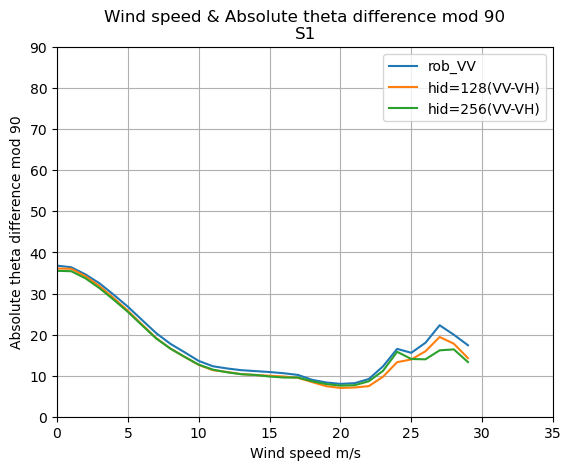

In [77]:
plt.plot(sig, res_rob, label='rob_VV')
plt.plot(sig, res_128, label='hid=128(VV-VH)')
plt.plot(sig, res_256, label='hid=256(VV-VH)')

plt.xlabel('Wind speed m/s')
plt.ylabel('Absolute theta difference mod 90')
plt.title('Wind speed & Absolute theta difference mod 90\nS1')
plt.grid()
plt.xlim(0,35)
plt.ylim(0, 90)
plt.legend()
plt.show()

# rob

In [39]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=1)
y_pred= predict(model, dataloader)

In [40]:
ds = xr.open_dataset(ds_path)

In [41]:
y_era5 = (ds.sel(pol='VV').era5_angle.values)%180

In [42]:
heading_angles = ds.sel(pol='VV').ground_heading.values
y_pred_norm = np.add(np.rad2deg(np.array(y_pred)), heading_angles)%180

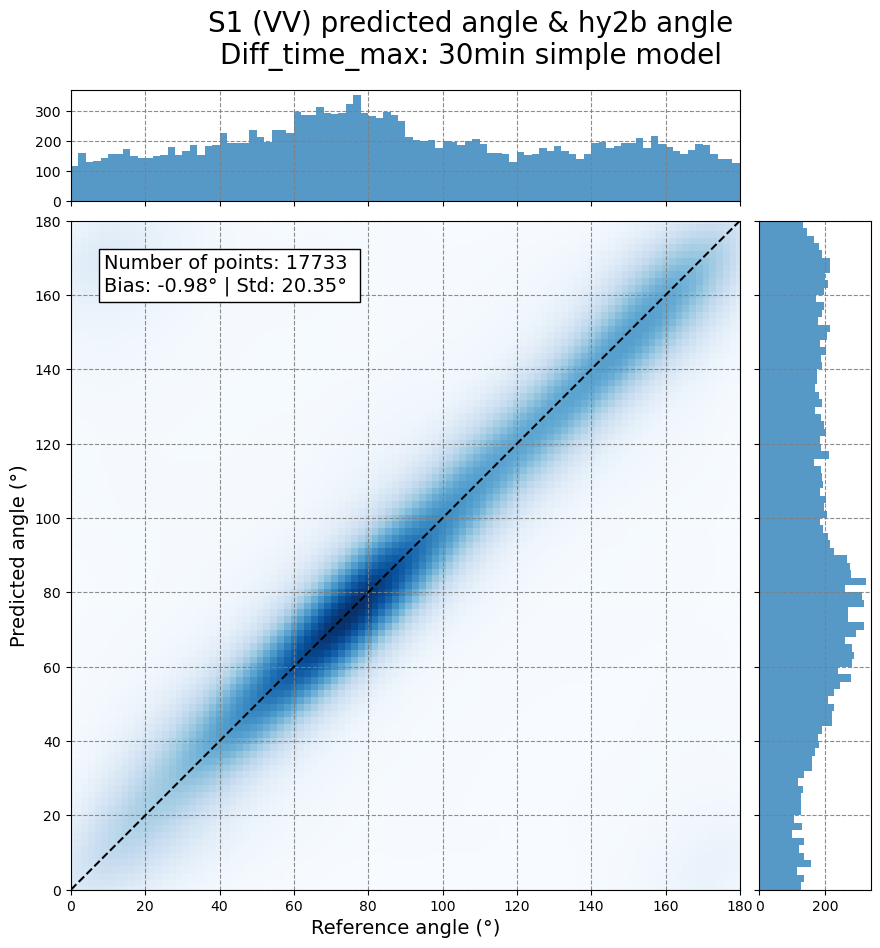

In [43]:
hist2d_prediction_vs_reference(x=y_era5, y=y_pred_norm, pred_std=None, title='simple model', pol='VV')

In [44]:
y_pred = ds.sel(pol='VV').pred_angle.values%180
# hist2d_prediction_vs_reference(x=y_era5, y=y_pred, pred_std=None, title='Robin model', pol='VV')

In [45]:
df_test = pd.DataFrame({
    'reference_angle' : y_era5,
    'Robin_pred' : y_pred,
    'Simple_model' : y_pred_norm
})
df_test

,reference_angle,Robin_pred,Simple_model
0,110.560541,109.124376,110.174363
1,5.649133,176.280529,146.051416
2,16.811910,173.566299,154.599214
3,1.699162,123.448900,92.770357
4,114.001816,109.238437,107.171788
...,...,...,...
17728,151.811322,143.776465,141.386505
17729,35.191128,29.344941,23.498218
17730,147.699365,142.952144,135.215260
17731,11.701563,147.767403,154.845854


In [46]:
import math
import torch

In [47]:
y_true = torch.tensor(np.deg2rad(df_test['reference_angle'].values), dtype=torch.float32)
y_pred_rob = torch.tensor(np.deg2rad(df_test['Robin_pred'].values), dtype=torch.float32)

rob_test_loss = loss_cos(y_true, y_pred_rob)
rob_test_err = err_calculation(y_true, y_pred_rob)
print(rob_test_loss, rob_test_err)

tensor(0.0749) tensor(0.3307)


In [48]:
step_size = 32

y_true_chunks = torch.split(y_true, step_size)
y_pred_rob_chunks = torch.split(y_pred_rob, step_size)

rob_test_loss_list = [loss_cos(y_true_chunk, y_pred_chunk).item() for y_true_chunk, y_pred_chunk in zip(y_true_chunks, y_pred_rob_chunks)]
rob_test_err_list = [err_calculation(y_true_chunk, y_pred_chunk).item() for y_true_chunk, y_pred_chunk in zip(y_true_chunks, y_pred_rob_chunks)]

print(rob_test_loss_list, rob_test_err_list) 

[0.1598607897758484, 0.06925450265407562, 0.07645007222890854, 0.07458949834108353, 0.010377839207649231, 0.11729317158460617, 0.06651493906974792, 0.007223581895232201, 0.04872564971446991, 0.03102043643593788, 0.07941531389951706, 0.11686509847640991, 0.1511080116033554, 0.08474884182214737, 0.15314863622188568, 0.09951941668987274, 0.06287652254104614, 0.061812181025743484, 0.15013635158538818, 0.1445072889328003, 0.058308154344558716, 0.09184859693050385, 0.034279339015483856, 0.09618614614009857, 0.06762392073869705, 0.13232317566871643, 0.05829066038131714, 0.05784060060977936, 0.09711355715990067, 0.06963814795017242, 0.0661383643746376, 0.13687816262245178, 0.06443263590335846, 0.08701971918344498, 0.06969990581274033, 0.03568501025438309, 0.04374006390571594, 0.06212901696562767, 0.05296657234430313, 0.07267798483371735, 0.06463868170976639, 0.06385395675897598, 0.011031758040189743, 0.0624987855553627, 0.03624822944402695, 0.10171109437942505, 0.09675955772399902, 0.129838407

In [49]:
print(np.mean(rob_test_loss_list), np.mean(rob_test_err_list))

0.07503489769055499 0.33105961163570213


In [50]:
y_true = torch.tensor(np.deg2rad(df_test['reference_angle'].values), dtype=torch.float32)
y_pred_ren = torch.tensor(np.deg2rad(df_test['Simple_model'].values), dtype=torch.float32)

ren_test_loss = loss_cos(y_true, y_pred_ren)
ren_test_err = err_calculation(y_true, y_pred_ren)

print(ren_test_loss, ren_test_err)

tensor(0.0808) tensor(0.3538)


In [51]:
step_size = 512

y_true_chunks = torch.split(y_true, step_size)
y_pred_ren_chunks = torch.split(y_pred_ren, step_size)

ren_test_loss_list = [loss_cos(y_true_chunk, y_pred_chunk).item() for y_true_chunk, y_pred_chunk in zip(y_true_chunks, y_pred_ren_chunks)]
ren_test_err_list = [err_calculation(y_true_chunk, y_pred_chunk).item() for y_true_chunk, y_pred_chunk in zip(y_true_chunks, y_pred_ren_chunks)]


print(ren_test_loss_list, ren_test_err_list)

[0.09046699106693268, 0.08273160457611084, 0.07246959954500198, 0.07649194449186325, 0.0775076299905777, 0.0995996743440628, 0.06759220361709595, 0.09363783150911331, 0.09482406079769135, 0.07158534973859787, 0.08807412534952164, 0.09102566540241241, 0.0734664723277092, 0.0796353667974472, 0.09593836963176727, 0.08367776870727539, 0.08951263129711151, 0.08513033390045166, 0.07741087675094604, 0.08763677626848221, 0.07966116815805435, 0.08424993604421616, 0.07530117779970169, 0.06693986803293228, 0.07992058992385864, 0.0858670026063919, 0.07620839029550552, 0.07062841206789017, 0.07738487422466278, 0.05700254812836647, 0.08037007600069046, 0.08568881452083588, 0.07565286755561829, 0.08329397439956665, 0.06760986149311066] [0.39060789346694946, 0.3596726357936859, 0.3340338170528412, 0.34414830803871155, 0.34506404399871826, 0.4003531336784363, 0.3154935836791992, 0.38880959153175354, 0.39376765489578247, 0.32477694749832153, 0.3759957253932953, 0.3825463652610779, 0.3316601812839508, 0.

In [52]:
print(np.mean(ren_test_loss_list), np.mean(ren_test_err_list))

0.08069128106747354 0.35343867795807976


# augmentation

In [127]:
def data_augmentation_layer(x):
    return torch.rot90(x, np.random.choice([2, 3]))